In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
from tabulate import tabulate
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge
from catboost import CatBoostRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from keras import optimizers
from tensorflow.keras import Model
from tensorflow.keras.layers import Input,Dense
from tensorflow.keras.losses import mae
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.datasets import fetch_california_housing

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('insurance.csv')

In [3]:
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


## EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

#### age

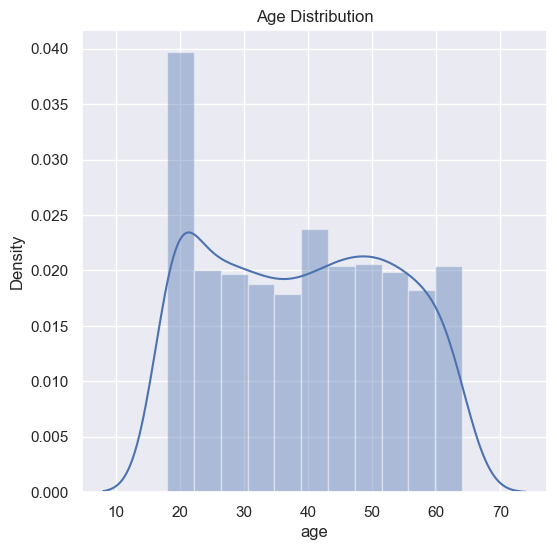

In [6]:
sns.set()
plt.figure(figsize=(6,6))
sns.distplot(df['age'])
plt.title('Age Distribution')
plt.show()

#### sex

In [7]:
df['sex'].value_counts()

sex
male      676
female    662
Name: count, dtype: int64

#### bmi

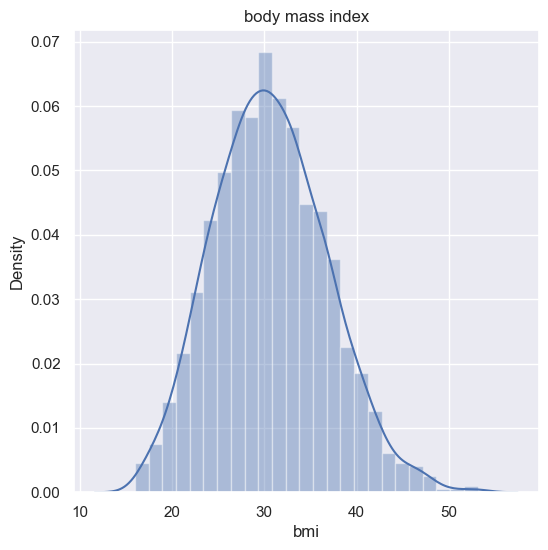

In [8]:
sns.set()
plt.figure(figsize=(6,6))
sns.distplot(df['bmi'])
plt.title('body mass index')
plt.show()

#### children

In [9]:
df['children'].value_counts()

children
0    574
1    324
2    240
3    157
4     25
5     18
Name: count, dtype: int64

#### smoker

In [10]:
df['smoker'].value_counts()

smoker
no     1064
yes     274
Name: count, dtype: int64

#### region

In [11]:
df['region'].value_counts()

region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64

#### features encoding

In [12]:
obj_cols = df.select_dtypes(include=['object']).columns
obj_cols

Index(['sex', 'smoker', 'region'], dtype='object')

In [13]:
df[obj_cols] = OrdinalEncoder().fit_transform(df[obj_cols])

In [14]:
df

,age,sex,bmi,children,smoker,region,charges
0,19,0.0,27.900,0,1.0,3.0,16884.92400
1,18,1.0,33.770,1,0.0,2.0,1725.55230
2,28,1.0,33.000,3,0.0,2.0,4449.46200
3,33,1.0,22.705,0,0.0,1.0,21984.47061
4,32,1.0,28.880,0,0.0,1.0,3866.85520
...,...,...,...,...,...,...,...
1333,50,1.0,30.970,3,0.0,1.0,10600.54830
1334,18,0.0,31.920,0,0.0,0.0,2205.98080
1335,18,0.0,36.850,0,0.0,2.0,1629.83350
1336,21,0.0,25.800,0,0.0,3.0,2007.94500


#### the correlation between features

<Axes: >

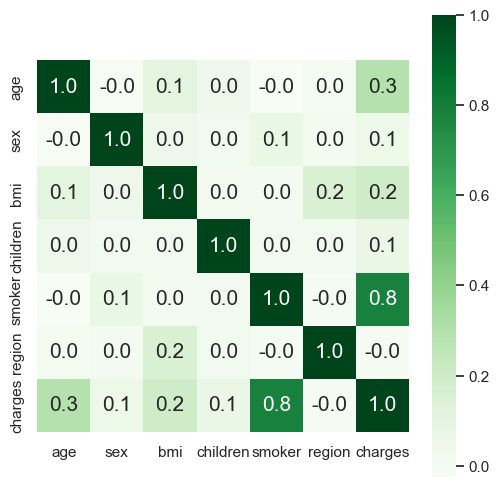

In [15]:
corr = df.corr()
plt.figure(figsize=(6,6))
sns.heatmap(corr, cbar=True, square= True, fmt='.1f', annot=True, annot_kws={'size':15}, cmap='Greens')

#### target

In [16]:
target = 'charges'

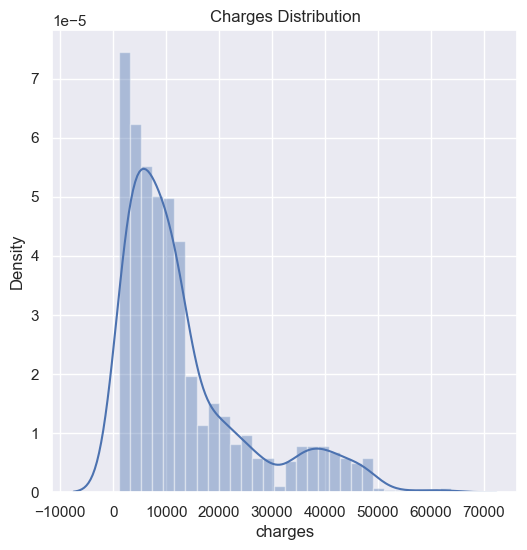

In [17]:
# distribution of charges value
plt.figure(figsize=(6,6))
sns.distplot(df['charges'])
plt.title('Charges Distribution')
plt.show()

#### split into features and target

In [18]:
df

,age,sex,bmi,children,smoker,region,charges
0,19,0.0,27.900,0,1.0,3.0,16884.92400
1,18,1.0,33.770,1,0.0,2.0,1725.55230
2,28,1.0,33.000,3,0.0,2.0,4449.46200
3,33,1.0,22.705,0,0.0,1.0,21984.47061
4,32,1.0,28.880,0,0.0,1.0,3866.85520
...,...,...,...,...,...,...,...
1333,50,1.0,30.970,3,0.0,1.0,10600.54830
1334,18,0.0,31.920,0,0.0,0.0,2205.98080
1335,18,0.0,36.850,0,0.0,2.0,1629.83350
1336,21,0.0,25.800,0,0.0,3.0,2007.94500


In [19]:
features = df.columns.drop(target)
features

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region'], dtype='object')

In [20]:
X = df[features]
y = df[target]

#### test train split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                   random_state=104, 
                                   test_size=0.2, 
                                   shuffle=True)

In [22]:
X_train.shape, X_test.shape

((1070, 6), (268, 6))

In [23]:
X_train_scaled = MinMaxScaler().fit_transform(X_train)
X_test_scaled = MinMaxScaler().fit_transform(X_test)
y_train_scaled = MinMaxScaler().fit_transform(np.array(y_train).reshape(-1,1))
y_test_scaled = MinMaxScaler().fit_transform(np.array(y_test).reshape(-1,1))

In [24]:
def print_metrics(y_test,y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    rmse = RMSE(y_test, y_pred)
    print(f"MAE {mae}")
    print(f"RMSE {rmse}")
    return mae, rmse

In [25]:
def plot_stats(y_train, y_pred):
    plt.figure(figsize=(8,8))
    plt.scatter(y_train, y_pred, s=10)
    plt.xlabel("Prices")
    plt.ylabel("Predicted prices")
    plt.title("Prices vs Predicted prices")
    plt.show()

In [26]:
def RMSE(y, y_hat):
    return np.sqrt(mean_squared_error(y,y_hat))

## Models builing

In [27]:
metrics = {}

## Random Forest

In [28]:
rfr = RandomForestRegressor(max_depth=5, random_state=0, n_estimators=500)
rfr.fit(X_train_scaled, y_train_scaled)

RandomForestRegressor(max_depth=5, n_estimators=500, random_state=0)

In [29]:
y_pred_scaled = rfr.predict(X_test_scaled)

In [30]:
metrics_rf = print_metrics(y_test_scaled, y_pred_scaled)
metrics['Random Forest'] = metrics_rf

MAE 0.08108221667067368
RMSE 0.14272531707274586


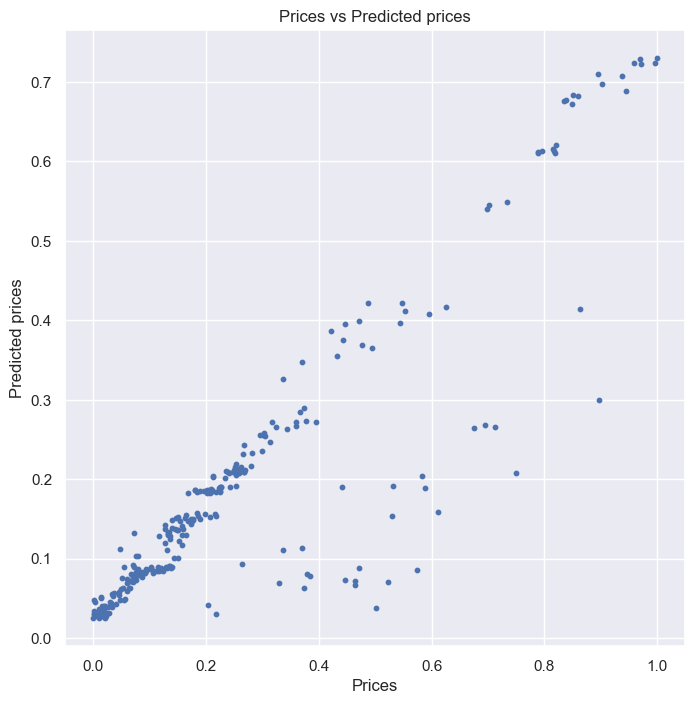

In [31]:
plot_stats(y_test_scaled, y_pred_scaled)

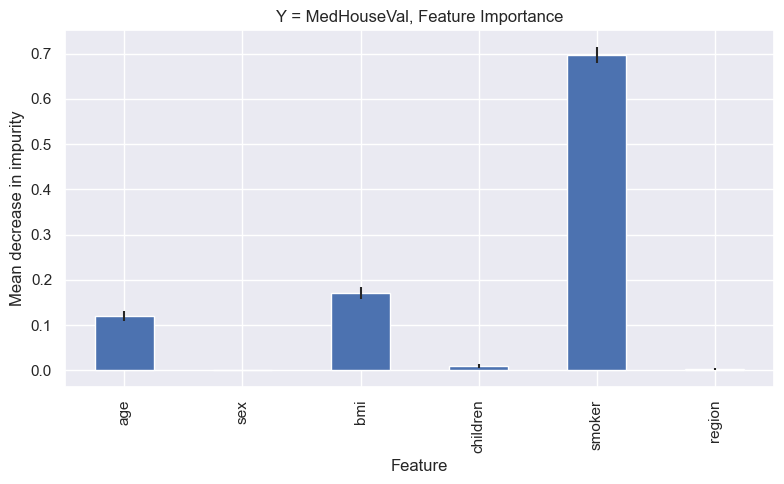

In [32]:
importances = rfr.feature_importances_
feature_names = [f"{i}" for i in X_test.columns]

forest_importances = pd.Series(importances, index=feature_names)
std = np.std([tree.feature_importances_ for tree in rfr.estimators_], axis=0)

fig, ax = plt.subplots(figsize=(8,5))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title(f"Y = MedHouseVal, Feature Importance")
ax.set_ylabel("Mean decrease in impurity")
ax.set_xlabel("Feature")
fig.tight_layout()

## XGBoost

In [33]:
import xgboost as xgb

In [34]:
params_xgb = {'n_estimators': 1000, 'random_state':0}

In [35]:
xgb = xgb.XGBRegressor(
        **params_xgb,
        objective='reg:squarederror')

In [36]:
xgb.fit(X_train_scaled, y_train_scaled)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=0, ...)

In [37]:
y_pred_scaled = xgb.predict(X_test_scaled)

In [38]:
metrics_rf = print_metrics(y_test_scaled, y_pred_scaled)
metrics['XGB'] = metrics_rf

MAE 0.08994533464754505
RMSE 0.145197099645365


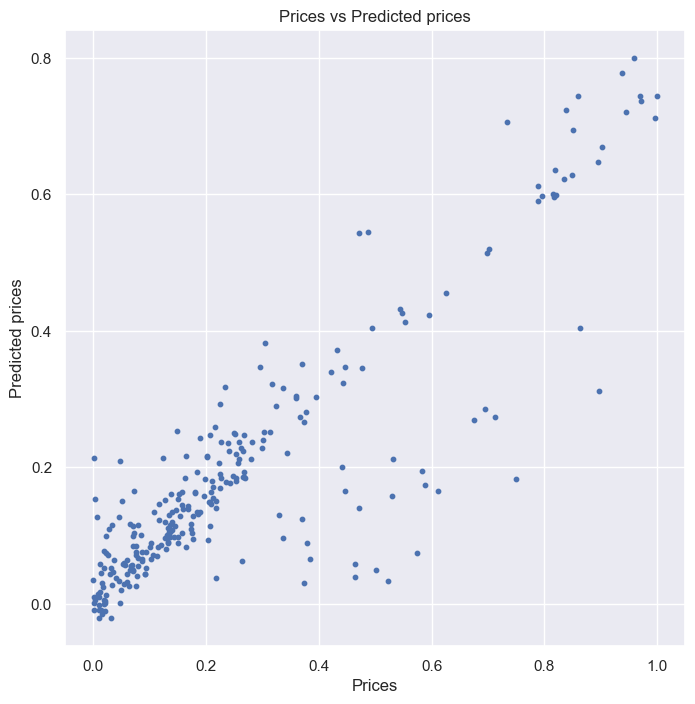

In [39]:
plot_stats(y_test_scaled, y_pred_scaled)

## Linear Regression

In [40]:
linear = LinearRegression()
linear.fit(X_train_scaled, y_train_scaled)

LinearRegression()

In [41]:
y_pred_scaled = linear.predict(X_test_scaled)

In [42]:
metrics_rf = print_metrics(y_test_scaled, y_pred_scaled)
metrics['Linear regression'] = metrics_rf

MAE 0.09287427370828961
RMSE 0.15435406706895996


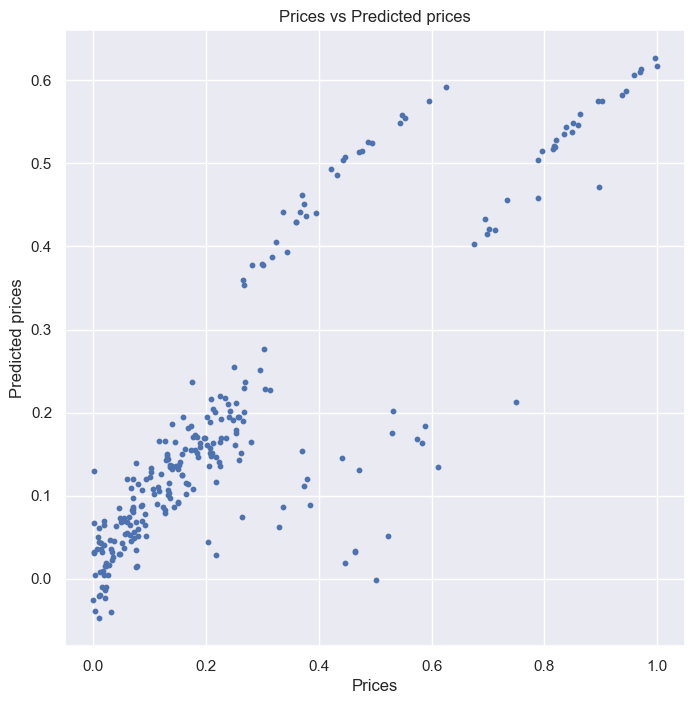

In [43]:
plot_stats(y_test_scaled, y_pred_scaled)

## LGBM

In [44]:
params_lgb = {
    "n_estimators": 1000,
    "verbose": -1
}

In [45]:
lgbm = LGBMRegressor(**params_lgb)
lgbm.fit(X_train_scaled, y_train_scaled)

LGBMRegressor(n_estimators=1000, verbose=-1)

In [46]:
y_pred_scaled = lgbm.predict(X_test_scaled)

In [47]:
metrics_rf = print_metrics(y_test_scaled, y_pred_scaled)
metrics['LGBM'] = metrics_rf

MAE 0.09329754900550358
RMSE 0.14791281516432803


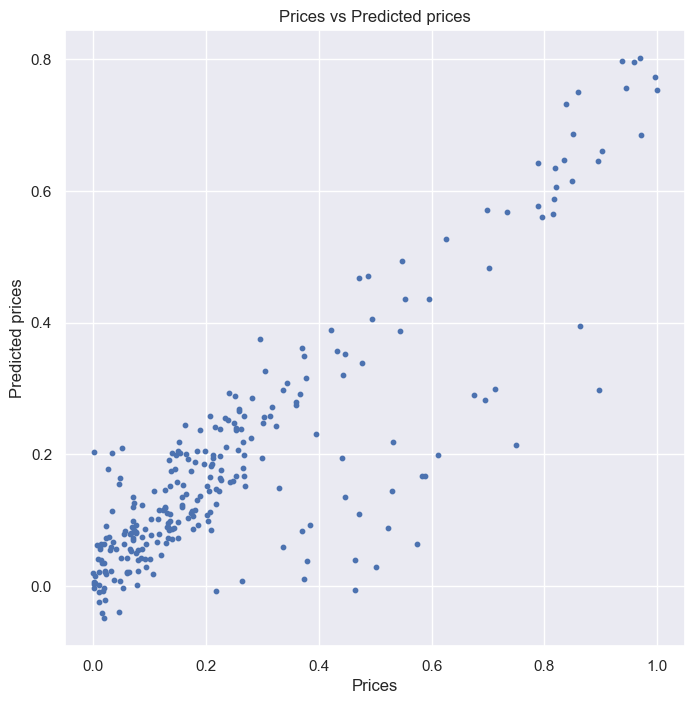

In [48]:
plot_stats(y_test_scaled, y_pred_scaled)

## Neural Network

In [49]:
input_dim = X_train_scaled.shape[1]

learning_rate = 1e-5

input_layer = Input(shape=(input_dim, ))
x = Dense(512, activation="tanh")(input_layer)
x = Dense(128, activation="tanh")(x)
x = Dense(16, activation="relu")(x)
ounput_layer = Dense(1, activation="relu")(x)

model = Model(inputs=input_layer, outputs=ounput_layer)

In [50]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 6)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │           2,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 71,329 (278.63 KB)

 Trainable params: 71,329 (278.63 KB)

 Non-trainable params: 0 (0.00 B)

In [51]:
opt = optimizers.Adam(learning_rate=0.0001)
model.compile(loss='mean_squared_error', optimizer=opt)

In [52]:
y_train_scaled.shape

(1070, 1)

In [53]:
history = model.fit(X_train_scaled, y_train_scaled,
                    epochs=50,
                    batch_size=20,
                    verbose=1,
                    )

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0206
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0099
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0075
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0074
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0076
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0064
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0068
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0064
Epoch 9/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0059
Epoch 10/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0060
Epoch 11/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0061
Epoch 12/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0065
Epoch 13/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0062
Epoch 14/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0059    
Epoch 15/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0060
Epoch 16/50
54/

In [54]:
y_pred_scaled = model.predict(X_test_scaled)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [55]:
metrics_rf = print_metrics(y_test_scaled, y_pred_scaled)
metrics['Neural network'] = metrics_rf

MAE 0.07849068314011583
RMSE 0.13465531510068113


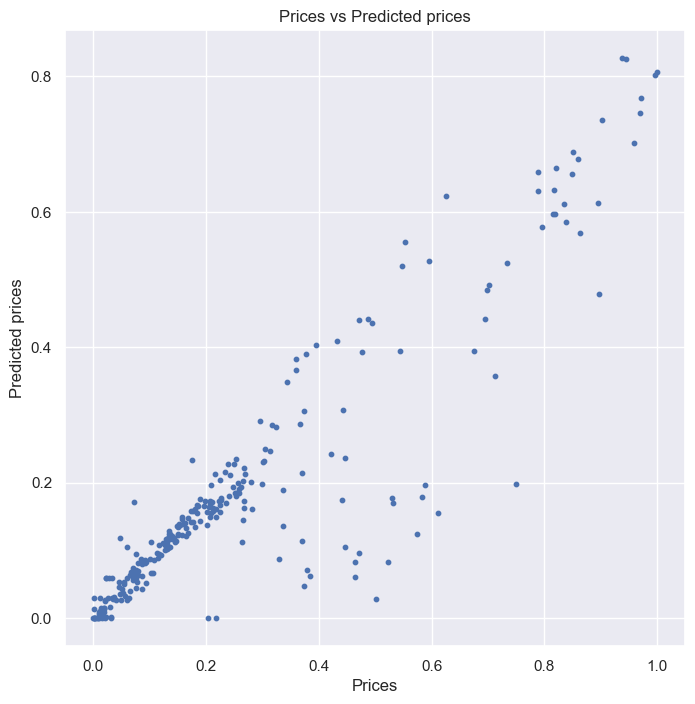

In [56]:
plot_stats(y_test_scaled, y_pred_scaled)

## CatBoost

In [57]:
cat = CatBoostRegressor(iterations=5000,
                        verbose = 500,
                        eval_metric='RMSE',
                        max_depth = 6,
                        subsample=0.7,
                        learning_rate = 0.04)
cat.fit(X_train_scaled, y_train_scaled, eval_set=[(X_test_scaled, y_test_scaled)], early_stopping_rounds=1000)

0:	learn: 0.1882265	test: 0.2559470	best: 0.2559470 (0)	total: 146ms	remaining: 12m 12s
500:	learn: 0.0507037	test: 0.1402793	best: 0.1395152 (211)	total: 768ms	remaining: 6.9s
1000:	learn: 0.0396360	test: 0.1412271	best: 0.1395152 (211)	total: 1.42s	remaining: 5.66s
Stopped by overfitting detector  (1000 iterations wait)

bestTest = 0.1395152023
bestIteration = 211

Shrink model to first 212 iterations.


In [58]:
y_pred_scaled = cat.predict(X_test_scaled)

In [59]:
metrics_rf = print_metrics(y_test_scaled, y_pred_scaled)
metrics['Catboost'] = metrics_rf

MAE 0.07838771844696513
RMSE 0.13951520220432193


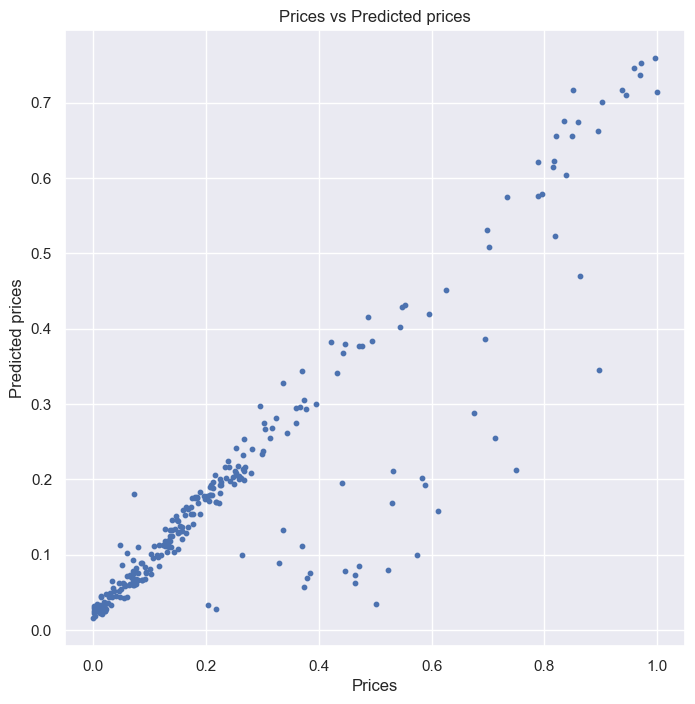

In [60]:
plot_stats(y_test_scaled, y_pred_scaled)

## BayesianRidge

In [61]:
bay_ridge = BayesianRidge()
bay_ridge.fit(X_train_scaled, y_train_scaled)

BayesianRidge()

In [62]:
y_pred_scaled = bay_ridge.predict(X_test_scaled)

In [63]:
metrics_rf = print_metrics(y_test_scaled, y_pred_scaled)
metrics['BayesianRidge'] = metrics_rf

MAE 0.09282212832687076
RMSE 0.15443468436618646


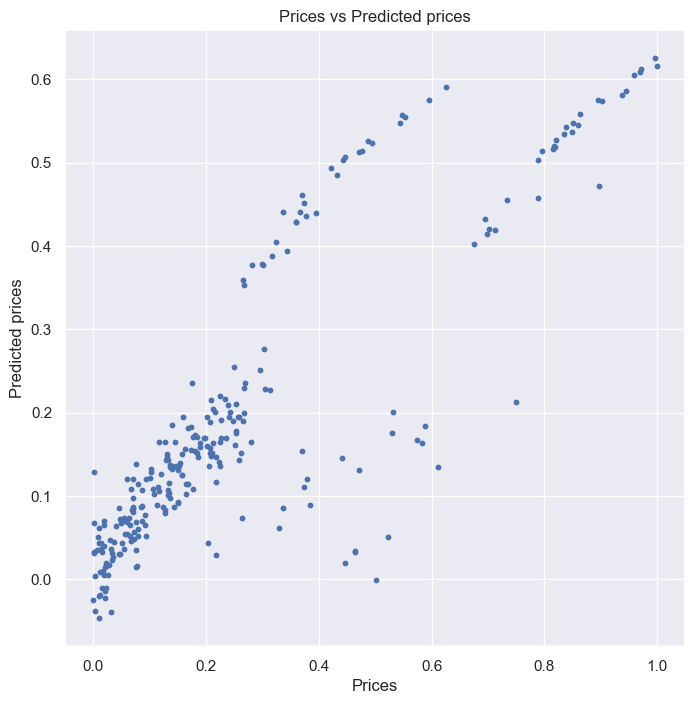

In [64]:
plot_stats(y_test_scaled, y_pred_scaled)

## SVM

In [65]:
svr = SVR(C=1.0, epsilon=0.2)
svr.fit(X_train_scaled, y_train_scaled)

SVR(epsilon=0.2)

In [66]:
y_pred_scaled = svr.predict(X_test_scaled)

In [67]:
metrics_rf = print_metrics(y_test_scaled, y_pred_scaled)
metrics['SVM'] = metrics_rf

MAE 0.14847581046016287
RMSE 0.16260737105229042


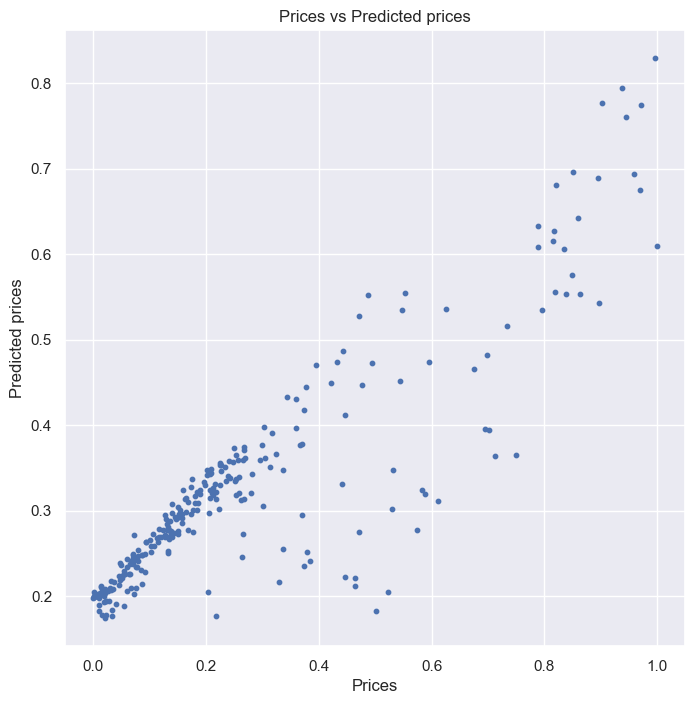

In [68]:
plot_stats(y_test_scaled, y_pred_scaled)

# Conclusion



In [69]:
table = []
table.append(['S.No.', 'MAE', 'RMSE'])
count = 1
models = ['Random Forest', 'XGB', 'Linear regression', 'LGBM', 'Neural network', 'Catboost', 'BayesianRidge','SVM']
for model in models:
    row = [count, model, metrics[model][0], metrics[model][1]]
    table.append(row)
    count += 1
print(tabulate(table, headers = 'firstrow', tablefmt = 'fancy_grid'))

╒════╤═══════════════════╤═══════════╤══════════╕
│    │ S.No.             │       MAE │     RMSE │
╞════╪═══════════════════╪═══════════╪══════════╡
│  1 │ Random Forest     │ 0.0810822 │ 0.142725 │
├────┼───────────────────┼───────────┼──────────┤
│  2 │ XGB               │ 0.0899453 │ 0.145197 │
├────┼───────────────────┼───────────┼──────────┤
│  3 │ Linear regression │ 0.0928743 │ 0.154354 │
├────┼───────────────────┼───────────┼──────────┤
│  4 │ LGBM              │ 0.0932975 │ 0.147913 │
├────┼───────────────────┼───────────┼──────────┤
│  5 │ Neural network    │ 0.0784907 │ 0.134655 │
├────┼───────────────────┼───────────┼──────────┤
│  6 │ Catboost          │ 0.0783877 │ 0.139515 │
├────┼───────────────────┼───────────┼──────────┤
│  7 │ BayesianRidge     │ 0.0928221 │ 0.154435 │
├────┼───────────────────┼───────────┼──────────┤
│  8 │ SVM               │ 0.148476  │ 0.162607 │
╘════╧═══════════════════╧═══════════╧══════════╛


#### All models performed well, but Catboost and neural net are slightly better than the others